## Fastai model built from scratch

This notebook shows image classification using fastai without usg pretrained model

First, import everything needed.

In [1]:
# Python imports
import PIL.Image as Image
import os
import glob
import pandas as pd
import numpy as np

# PyTorch imports
import torch
import torch.nn as nn
import torch.functional as F


# fastai imports
from fastai.vision.all import *

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


What is the size of our images?

In [2]:
folder_path = r'/kaggle/input/chess-pieces/all_resized_into_sub_folders_640'

In [3]:
pattern = folder_path + r'/*/*.jpg'

image_path_list = glob.glob(pattern)


# write an check code to confirm that all images in all folders have size (640,640)
image_size_list = []
for image_path in image_path_list:
    size = Image.open(image_path).size
    image_size_list.append(size) 

print(np.unique(np.array(image_size_list)))

[640]


Now let's build our Datablock

In [4]:
chess_datablock = DataBlock(blocks=(ImageBlock(), CategoryBlock()),
                      get_items=get_image_files,
                      get_y=parent_label,
                      splitter=RandomSplitter(seed=900),
                      item_tfms=FlipItem(p=0.5),
                      batch_tfms=aug_transforms(pad_mode='zeros', flip_vert=True, max_lighting=0.5 )
                        )

chess_datablock.summary(folder_path)

Setting-up type transforms pipelines
Found 300 items
2 datasets of sizes 240,60
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /kaggle/input/chess-pieces/all_resized_into_sub_folders_640/Black rook/resized_1691046037143.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=640x640
  Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /kaggle/input/chess-pieces/all_resized_into_sub_folders_640/Black rook/resized_1691046037143.jpg
    applying parent_label gives
      Black rook
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(5)

Final sample: (PILImage mode=RGB size=640x640, TensorCategory(5))


Found 300 items
2 datasets of sizes 240,60
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -

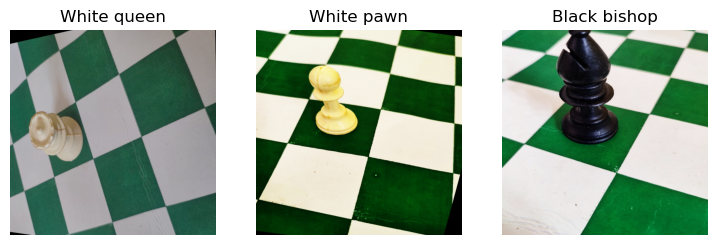

In [5]:
chess_dls = chess_datablock.dataloaders(folder_path)
chess_dls.show_batch(nrows=1, ncols=3
                     )

Let's build the CNN model using torch

In [6]:
chess_model = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=8, kernel_size=(3,3)),
    nn.ReLU(),
    nn.Conv2d(in_channels=8, out_channels=1, kernel_size=(1,1)),
    nn.Flatten(),
    nn.Linear(407044, 12)
)

chess_model

Sequential(
  (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): Conv2d(8, 1, kernel_size=(1, 1), stride=(1, 1))
  (3): Flatten(start_dim=1, end_dim=-1)
  (4): Linear(in_features=407044, out_features=12, bias=True)
)

The fastai Learner

In [7]:
learn_resnet = Learner(chess_dls, resnet18(weights=None), loss_func=F.cross_entropy, metrics=accuracy)
learn_resnet.summary()

ResNet (Input shape: 64 x 3 x 640 x 640)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 64 x 320 x 320 
Conv2d                                    9408       True      
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 64 x 160 x 160 
MaxPool2d                                                      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
ReLU                          

In [8]:
learn_chess_model = Learner(chess_dls, chess_model, loss_func=F.cross_entropy, metrics=accuracy)
learn_chess_model.summary()

Sequential (Input shape: 64 x 3 x 640 x 640)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 8 x 638 x 638  
Conv2d                                    224        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 1 x 638 x 638  
Conv2d                                    9          True      
____________________________________________________________________________
                     64 x 407044         
Flatten                                                        
____________________________________________________________________________
                     64 x 12             
Linear                                    4884540    True      
____________________________________________________________________________

Total params: 4,884,773
Total trainable params: 4,884,773
Total non-trainable params: 0

Optim

fitting...

In [9]:
learn_resnet.fit_one_cycle(2, 0.01)

epoch,train_loss,valid_loss,accuracy,time
0,6.098675,110001.539062,0.066667,00:06
1,4.652659,39077.355469,0.066667,00:04


In [10]:
learn_chess_model.fit_one_cycle(2, 0.01)

epoch,train_loss,valid_loss,accuracy,time
0,69.990372,216.696274,0.016667,00:03
1,147.351089,105.061539,0.083333,00:02
